201.19197f0 (tracked)

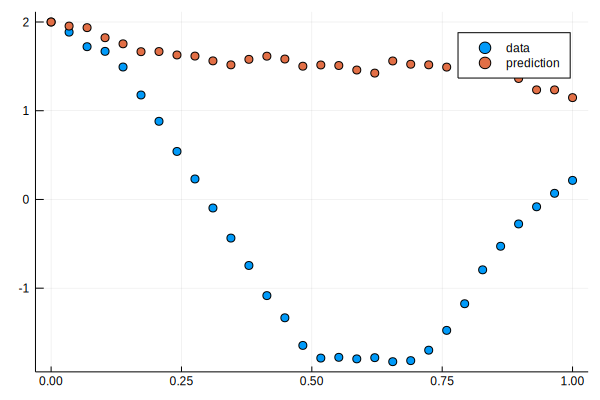

140.92732f0 (tracked)

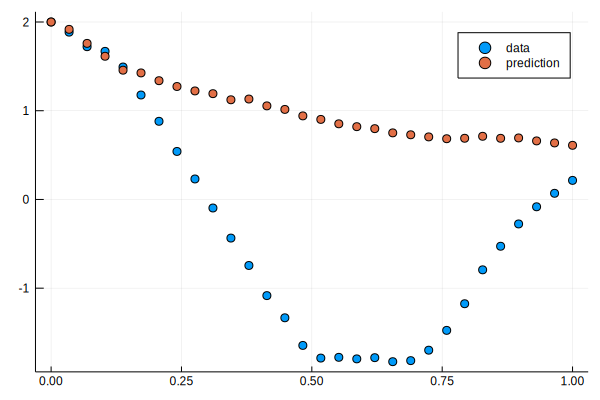

125.08997f0 (tracked)

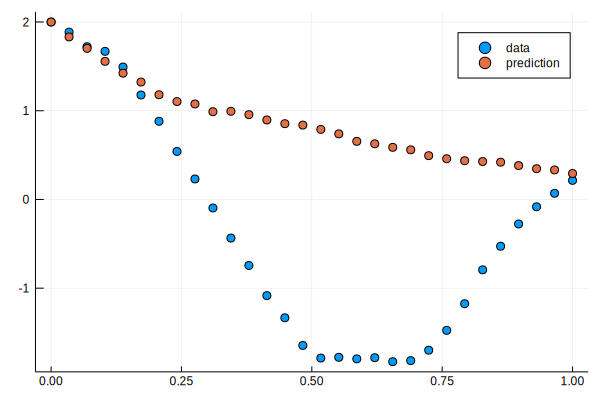

109.279686f0 (tracked)

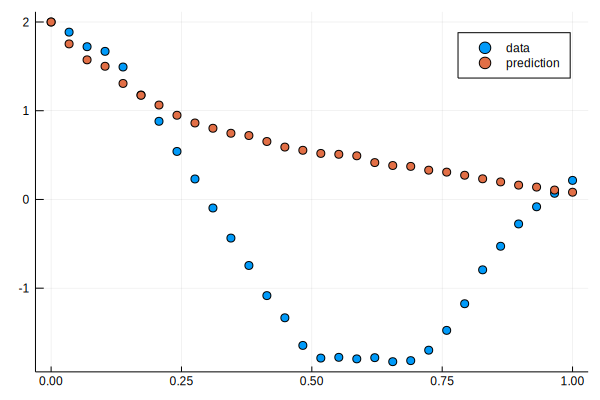

In [ ]:
using Flux, DiffEqFlux, DifferentialEquations, Plots

u0 = Float32[2.; 0.]
datasize = 30
tspan = (0.0f0,1.0f0)

function trueODEfunc(du,u,p,t)
    true_A = [-0.1 2.0; -2.0 -0.1]
    du .= ((u.^3)'true_A)'
end
t = range(tspan[1],tspan[2],length=datasize)
mp = Float32[0.2,0.2]
function true_noise_func(du,u,p,t)
    du .= mp.*u
end
prob = SDEProblem(trueODEfunc,true_noise_func,u0,tspan)
sde_data = Array(solve(prob,SOSRI(),saveat=t))

dudt = Chain(x -> x.^3,
             Dense(2,50,tanh),
             Dense(50,2))
ps = Flux.params(dudt)
n_sde = x->neural_dmsde(dudt,x,mp,tspan,SOSRI(),saveat=t,reltol=1e-2,abstol=1e-2)

pred = n_sde(u0) # Get the prediction using the correct initial condition
scatter(t,sde_data[1,:],label="data")
scatter!(t,Flux.data(pred[1,:]),label="prediction")

function predict_n_sde()
  n_sde(u0)
end
loss_n_sde() = sum(abs2,sde_data .- predict_n_sde())
Flux.back!(loss_n_sde())

data = Iterators.repeated((), 100)
opt = ADAM(0.025)
cb = function () #callback function to observe training
  sample = predict_n_sde()
  # loss against current data
  display(sum(abs2,sde_data .- sample))
  # plot current prediction against data
  cur_pred = Flux.data(sample)
  pl = scatter(t,sde_data[1,:],label="data")
  scatter!(pl,t,cur_pred[1,:],label="prediction")
  display(plot(pl))
end

# Display the SDE with the initial parameter values.
cb()

Flux.train!(loss_n_sde, ps, data, opt, cb = cb)